In [110]:
import pychemelt as pychem
import numpy as np
import pandas as pd

In [112]:
RNG_SEED = 2

rng = np.random.default_rng(RNG_SEED)

In [125]:
def aux_create_pychem_sim(params):

    concs = np.arange(1,4.5,0.5)

    # Calculate signal range for proper y-axis scaling
    temp_range = np.linspace(20, 90, 100)
    signal_list = []
    temp_list   = []

    for i,D in enumerate(concs):

        y = pychem.signal_two_state_tc_unfolding(temp_range, D, **params)

        # Add gaussian error to simulated signal
        y += rng.normal(0, 0.01, len(y))

        # Add error to the initial signal to model variance across positions
        y *= rng.uniform(0.9,1.1)

        signal_list.append(y)
        temp_list.append(temp_range)

    pychem_sim = pychem.Sample()

    pychem_sim.signal_dic['Fluo'] = signal_list
    pychem_sim.temp_dic['Fluo']   = [temp_range for _ in range(len(concs))]

    pychem_sim.conditions = concs

    pychem_sim.global_min_temp = np.min(temp_range)
    pychem_sim.global_max_temp = np.max(temp_range)

    pychem_sim.set_denaturant_concentrations()

    pychem_sim.set_signal('Fluo')

    pychem_sim.select_conditions(normalise_to_global_max=True)
    pychem_sim.expand_multiple_signal()

    return pychem_sim

In [134]:
def_params = {

     # Thermodynamic parameters

    'DHm': 100, # Enthalpy of unfolding
    'Tm': 140, # Temperature of unfolding
    'Cp0': 1, # Heat capacity of unfolding
    'm0': 3.2, # m-value of unfolding
    'm1': 0, # m-dependence on temperature, not modelled

    # Native baseline parameters

    'p1_N': 2.5,  # dependence on denaturant concentration
    'p2_N': 24,   # intercept
    'p3_N': -0.27,  # slope term
    'p4_N': 0, # quadratic term, ignored

    # Unfolded baseline parameters

    'p1_U': 1.6, # dependence on denaturant concentration
    'p2_U': -4, # intercept
    'p3_U': 80.5, # pre-exponential factor
    'p4_U': 0.0224, # exponential coefficient

    # Baseline functions

    'baseline_N_fx':pychem.linear_baseline,
    'baseline_U_fx':pychem.exponential_baseline
}


In [135]:
pychem_sim = aux_create_pychem_sim(def_params)

pychem_sim.estimate_derivative()
pychem_sim.guess_Tm()
pychem_sim.estimate_baseline_parameters(
    native_baseline_type='linear',
    unfolded_baseline_type='exponential'
)
pychem_sim.fit_thermal_unfolding_local()
pychem_sim.n_residues = 100 # only for cp initial guess
pychem_sim.guess_Cp()
pychem_sim.fit_thermal_unfolding_global(
    tm_limits=[90,150],
    dh_limits=[50,200]
)
pychem_sim.fit_thermal_unfolding_global_global()
pychem_sim.fit_thermal_unfolding_global_global_global(model_scale_factor=True)
fig = pychem.plot_unfolding(pychem_sim)
fig.show()
print(pychem_sim.params_df)

                                  Parameter       Value  Relative error (%)  \
0                                   Tm (°C)  139.990108            0.024577   
1                             ΔH (kcal/mol)  100.046473            0.056327   
2                          Cp (kcal/mol/°C)    1.000693            0.085499   
3                      m-value (kcal/mol/M)    3.200698            0.045599   
4                   intercept_native - Fluo   24.871314            0.082143   
5                 intercept_unfolded - Fluo   -4.108948            1.149466   
6                  slope_term_native - Fluo   -0.279808            0.069389   
7    pre_exponential_factor_unfolded - Fluo   83.360066            0.022626   
8       denaturant_slope_term_native - Fluo    2.593090            0.151730   
9     denaturant_slope_term_unfolded - Fluo    1.653315            0.730992   
10  exponential_coefficient_unfolded - Fluo    0.022409            0.041988   
11            Scale factor - 1.0 (M). ID: 0    1.149

In [102]:
def fit_pychem_sim(pychem_sim_x):

    pychem_sim_x.estimate_baseline_parameters(
        native_baseline_type='linear',
        unfolded_baseline_type='exponential'
    )

    pychem_sim_x.fit_thermal_unfolding_local()

    pychem_sim_x.n_residues = 150 # only for cp initial guess
    pychem_sim_x.guess_Cp()

    pychem_sim_x.fit_thermal_unfolding_global(
        #cp_limits=[0.5,3],
    )

    pychem_sim_x.fit_thermal_unfolding_global_global()
    pychem_sim_x.fit_thermal_unfolding_global_global_global(model_scale_factor=True)

    return None

In [103]:
def get_dg_df(Tm,DHm, Cp0):

    T_c = np.arange(0, 100, 0.5)
    T = T_c + 273.15
    Tm = Tm + 273.15

    DG = DHm * (1 - T / Tm) + Cp0 * (T - Tm - T * np.log(T / Tm))

    dg_df = pd.DataFrame({
        'DG (kcal/mol)': DG,
        'Temperature (°C)': T_c
    })

    return dg_df

In [104]:
import matplotlib.pyplot as plt

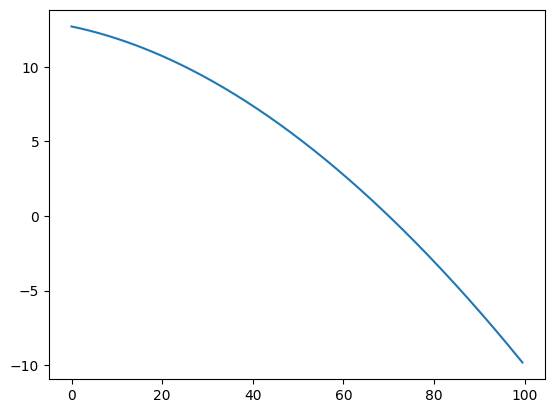

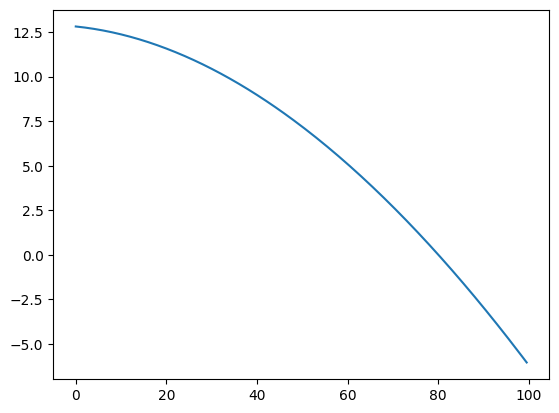

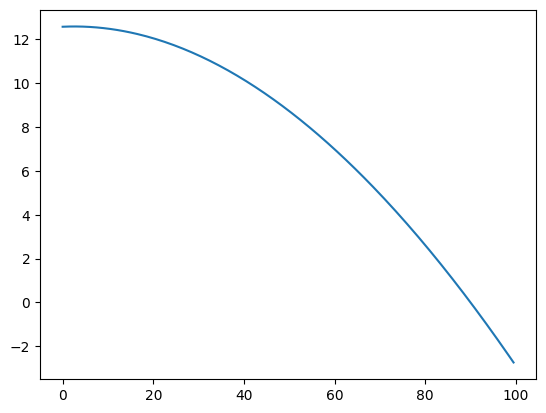

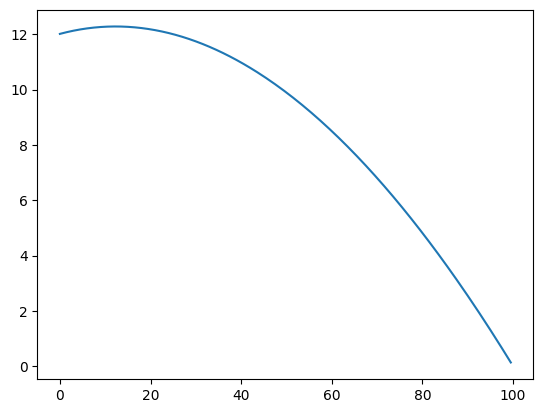

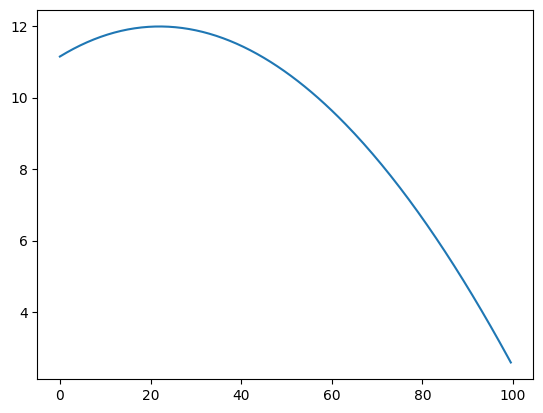

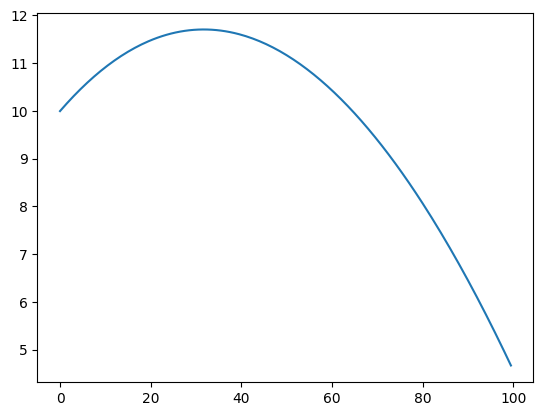

In [105]:
Tm_seq = np.arange(70,130,10)

for Tm in Tm_seq:

    dg_df = get_dg_df(Tm, def_params['DHm'], def_params['Cp0'])
    plt.plot(dg_df['Temperature (°C)'], dg_df['DG (kcal/mol)'], label=f'Tm={Tm} °C')
    plt.show()

Now we will simulate data with different Tms, fit it, and evaluate the accuracy of the fitted Tms.

In [106]:
for Tm in np.arange(70,130,10):

    params = def_params.copy()
    params['Tm'] = Tm

    pychem_sim = aux_create_pychem_sim(params)

    fit_pychem_sim(pychem_sim)

    params = pychem_sim.params_df
    #print(params[:4])
    fig = pychem.plot_unfolding(pychem_sim)
    fig.show()

    fitted_Tm = params.iloc[0,1]

    print(f"Simulated Tm: {Tm} °C, Fitted Tm: {fitted_Tm:.2f} °C")

Simulated Tm: 70 °C, Fitted Tm: 70.00 °C


Simulated Tm: 80 °C, Fitted Tm: 80.01 °C


Simulated Tm: 90 °C, Fitted Tm: 89.99 °C


/home/os/pychemelt_analyses/.venv/lib/python3.12/site-packages/scipy/optimize/_lsq/trf.py:353: RuntimeWarning:

overflow encountered in dot



Simulated Tm: 100 °C, Fitted Tm: 100.01 °C


Simulated Tm: 110 °C, Fitted Tm: 156.00 °C


Simulated Tm: 120 °C, Fitted Tm: 119.96 °C
